## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob
import time

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label
from helper_functions import *

%matplotlib inline

/Users/yhbyhb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 680] # Min and max in y to search in slide_window()

In [3]:
# Divide up into cars and notcars
files = glob.glob('fullset/**', recursive=True)
cars = []
notcars = []
for filename in files:
    if '.png' not in filename:
        continue
    if 'non-vehicles' in filename:
        notcars.append(filename)
    else:
        cars.append(filename)

print('{0} car images'.format(len(cars)))
print('{0} notcar images'.format(len(notcars)))

8792 car images
8968 notcar images


In [4]:
pickle_filename = 'saved_data.p'

svc = None
X_scaler = None
if not os.path.isfile(pickle_filename):
    t=time.time()
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)              
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract features and normalize')

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    pickle_data = {}
    pickle_data['svc'] = svc
    pickle_data['scaler'] = X_scaler
    pickle.dump(pickle_data, open(pickle_filename, 'wb'))
else:
    with open(pickle_filename, mode='rb') as f:
        data = pickle.load(f)
        svc = data['svc']
        X_scaler = data['scaler']
        print('Saved svc is loaded successfully')

Saved svc is loaded successfully


## Extracting Hog features

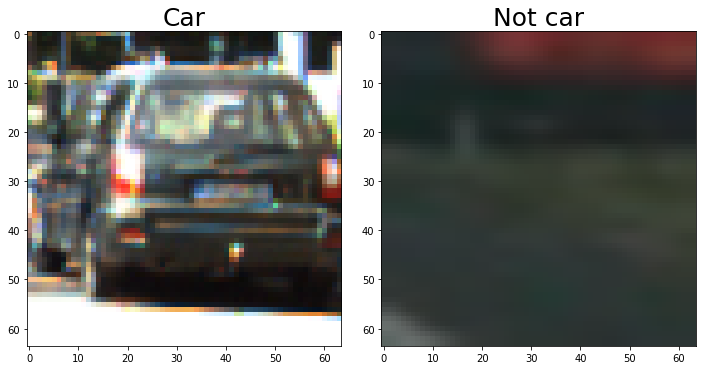

In [5]:
sample_car = mpimg.imread(cars[np.random.randint(0, len(cars))])
sample_notcar = mpimg.imread(notcars[np.random.randint(0, len(notcars))])

fontsize= 25
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(sample_car)
plt.title('Car', fontsize=fontsize)
plt.subplot(122)
plt.imshow(sample_notcar)
plt.title('Not car', fontsize=fontsize)
fig.tight_layout()

/Users/yhbyhb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


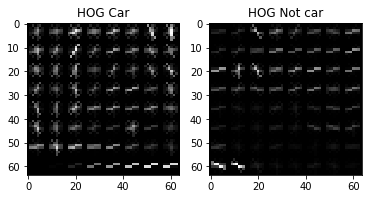

In [6]:
cvt_car = cv2.cvtColor(sample_car, cv2.COLOR_RGB2YCrCb)
cvt_notcar = cv2.cvtColor(sample_notcar, cv2.COLOR_RGB2YCrCb)

f_c_list = []
f_nc_list = []
hog_c_list = []
hog_nc_list = []

for ch in range(3):
    features_car, hog_car = get_hog_features(cvt_car[:,:,ch], orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)
    features_notcar, hog_notcar = get_hog_features(cvt_notcar[:,:,ch], orient, pix_per_cell, cell_per_block,
                                        vis=True, feature_vec=True)
    f_c_list.append(features_car)
    f_nc_list.append(features_notcar)
    hog_c_list.append(hog_car)
    hog_nc_list.append(hog_notcar)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(hog_c_list[0], cmap='gray')
plt.title('HOG Car')
plt.subplot(122)
plt.imshow(hog_nc_list[0], cmap='gray')
plt.title('HOG Not car')


## Sub-sampling window search 

In [7]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
              image_normalize=True):
    
    if image_normalize:
        img = img.astype(np.float32)/255
        
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=(0, 1))
            
            # print(spatial_features.shape, hist_features.shape, hog_features.shape)
            # print(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).shape)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bboxes

/Users/yhbyhb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


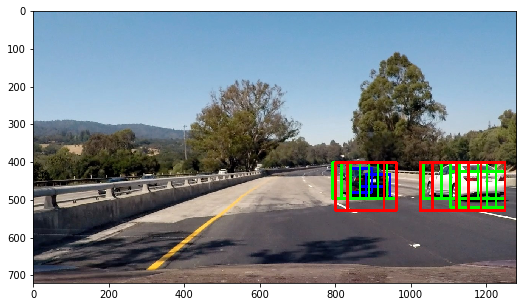

In [8]:
image = mpimg.imread('test_images/test4.jpg')

scale_list = [1, 1.5, 2]
color_list = [(0, 0, 255), (0, 255, 0), (255, 0,  0)]

bboxes_list = []
for scale in scale_list:
    bboxes = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes_list.append(bboxes)

window_img = np.copy(image)
for bboxes, color in zip(bboxes_list, color_list):
    window_img = draw_boxes(window_img, bboxes, color=color, thick=6)

plt.figure(figsize=(10, 5))
plt.imshow(window_img)

## Multiple Detections & False Positives

In [9]:
def add_heat(heatmap, bboxes):
    # Iterate through list of bboxes
    for box in bboxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and heatmap bboxes
    return img

def get_bboxes_from_labels(labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    # Return the image and heatmap bboxes
    return bboxes    

def draw_img_n_heatmap(img, heatmap, img_title='Car Positions'):
    fontsize= 25
    fig = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img)
    plt.title(img_title, fontsize=fontsize)
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map', fontsize=fontsize)
    fig.tight_layout()
    
def distance(p1, p2):
    return np.linalg.norm(p1 - p2)

def get_centroids(bboxes):
    centriods = []
    for bbox in bboxes:
        centriods.append((np.array(bbox[1]) + np.array(bbox[0])) / 2.0)
    return centriods

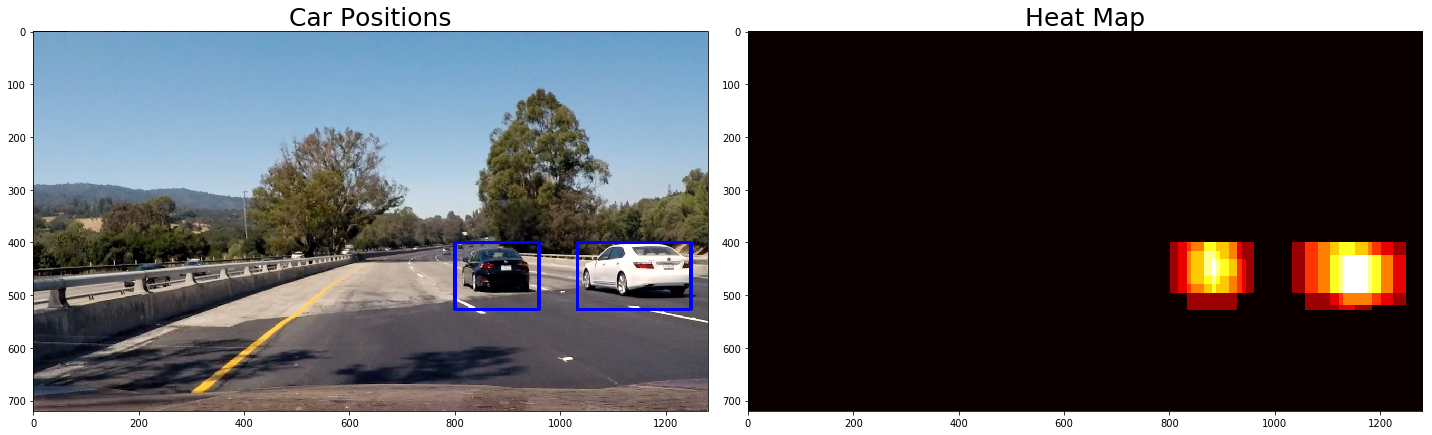

In [10]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
for bboxes in bboxes_list:
    heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_boxes(np.copy(image), get_bboxes_from_labels(labels))
    
draw_img_n_heatmap(draw_img, heatmap)

## Pipeline

In [11]:
bbox_lists = []
prev_heatmap_bboxes = []
centroids_list = []
def pipeline(image):
    global bbox_lists, prev_heatmap_bboxes, centroids_list
    scale_list = [1, 1.5, 2]
    bbox_list = []
    for scale in scale_list:
        bboxes = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in bboxes:
            bbox_list.append(bbox)
            
    bbox_lists.append(bbox_list)
    recent_bbox_lists = bbox_lists[-5:]
    
    recent_bboxes = []
    for tmp in recent_bbox_lists:
        for bbox in tmp:
            recent_bboxes.append(bbox)

    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,recent_bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1 * len(recent_bbox_lists))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find boxes from heatmap using label function
    labels = label(heatmap)
    heatmap_bboxes = get_bboxes_from_labels(labels)
    
    # previous centroid thresholding
    final_heatmap_bboxes = []
    dist_thres = 32
    if len(prev_heatmap_bboxes) > 0:
        for heatmap_bbox in heatmap_bboxes:
            dist = []
            centroid = (np.array(heatmap_bbox[1]) + np.array(heatmap_bbox[0])) / 2.0
#             print(centroid)
            for prev_bbox in prev_heatmap_bboxes:
                prev_centroid = (np.array(prev_bbox[1]) + np.array(prev_bbox[0])) / 2.0
#                 print('    {0}'.format(prev_centroid))
                dist.append(distance(centroid, prev_centroid))
            min_dist = np.min(dist)
#             print(min_dist)
            if min_dist <= dist_thres:
               final_heatmap_bboxes.append(heatmap_bbox)
    else:
        final_heatmap_bboxes = heatmap_bboxes
        
    # for new boxes
    current_centroids = get_centroids(heatmap_bboxes)
    centroids_list.append(current_centroids)
    recent_cc_thres = 3
    recent_centroids_list = centroids_list[-recent_cc_thres:]
#     print('recent_centroids_list')
#     for cc_list in recent_centroids_list:
#         print('    {0}'.format(cc_list))
    if len(recent_centroids_list) >= recent_cc_thres :
        for index, cc in enumerate(current_centroids):
            count = 0
            for prev_ccs in recent_centroids_list:
                dist = []
                for prev_cc in prev_ccs:
                    dist.append(distance(cc, prev_cc))
                if len(dist) == 0:
                    continue                    
                if 0 < np.min(dist) <= dist_thres:
                    count += 1
            if count == recent_cc_thres:
                final_heatmap_bboxes.append(heatmap_bboxes[index])    

#     print('final bboxes + {0}'.format(final_heatmap_bboxes))
    draw_img = draw_boxes(np.copy(image), final_heatmap_bboxes)
                
    prev_heatmap_bboxes = final_heatmap_bboxes
    
    return draw_img

## Test single images

In [12]:
test_files = glob.glob('test_images/*')
output_images = []
for test_file in test_files:
    image = mpimg.imread(test_file)
    bbox_lists = []
    prev_heatmap_bboxes = []
    centroids_list = []
    output_images.append(pipeline(image))

/Users/yhbyhb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


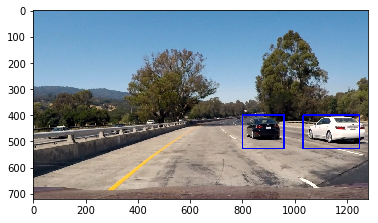

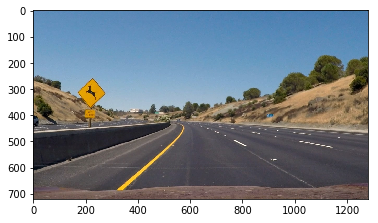

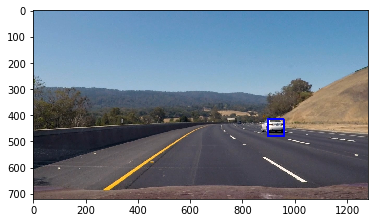

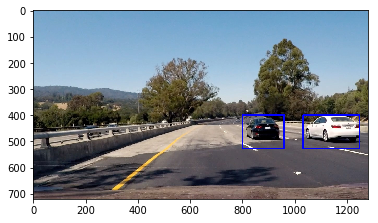

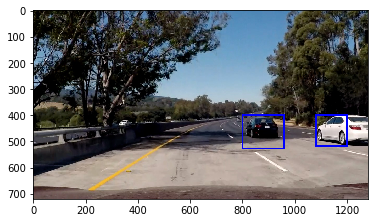

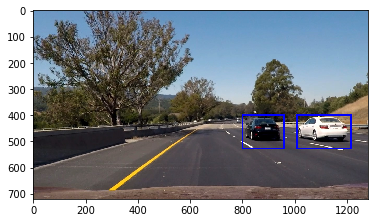

In [13]:
for image in output_images:
    plt.figure()
    plt.imshow(image)

## Apply to a test video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
bbox_lists = []
prev_heatmap_bboxes = []
centroids_list = []

test_output = "test_output.mp4"
test_clip = VideoFileClip('test_video.mp4')
test_output_clip = test_clip.fl_image(pipeline)
%time test_output_clip.write_videofile(test_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [01:33<00:02,  2.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 1min 28s, sys: 3.3 s, total: 1min 31s
Wall time: 1min 35s


## Project video

In [16]:
bbox_lists = []
prev_heatmap_bboxes = []
centroids_list = []

output = "output.mp4"
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [50:39<00:02,  2.34s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 47min 3s, sys: 1min 44s, total: 48min 48s
Wall time: 50min 41s


## Test code

In [19]:
clip = VideoFileClip('project_video.mp4')
difficult_clip = clip.subclip(6.3, 8)
idx = 0
bbox_lists = []
prev_heatmap_bboxes = []
centroids_list = []

for image in difficult_clip.iter_frames():
    filename = 'difficult/{0}.jpg'.format(idx)
    print(filename)
    
    scale_list = [1, 1.5, 2]
    bbox_list = []
    for scale in scale_list:
        bboxes = find_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        for bbox in bboxes:
            bbox_list.append(bbox)
            
    bbox_lists.append(bbox_list)
    recent_bbox_lists = bbox_lists[-5:]
#     print(len(recent_bbox_lists))
    
    recent_bboxes = []
    for tmp in recent_bbox_lists:
        for bbox in tmp:
            recent_bboxes.append(bbox)

    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,recent_bboxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1 * len(recent_bbox_lists))

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    heatmap_bboxes = get_bboxes_from_labels(labels)
    
    # previous centroid thresholding
    final_heatmap_bboxes = []
    dist_thres = 32
    if len(prev_heatmap_bboxes) > 0:
        
        for heatmap_bbox in heatmap_bboxes:
            dist = []
            centroid = (np.array(heatmap_bbox[1]) + np.array(heatmap_bbox[0])) / 2.0
            print(centroid)
            for prev_bbox in prev_heatmap_bboxes:
                prev_centroid = (np.array(prev_bbox[1]) + np.array(prev_bbox[0])) / 2.0
                print('    {0}'.format(prev_centroid))
                dist.append(distance(centroid, prev_centroid))
            min_dist = np.min(dist)
            print(min_dist)
            if min_dist <= dist_thres:
               final_heatmap_bboxes.append(heatmap_bbox)
    else:
        final_heatmap_bboxes = heatmap_bboxes
        
    # for new boxes
    current_centroids = get_centroids(heatmap_bboxes)
    centroids_list.append(current_centroids)
    recent_cc_thres = 3
    recent_centroids_list = centroids_list[-recent_cc_thres:]
    print('recent_centroids_list')
    for cc_list in recent_centroids_list:
        print('    {0}'.format(cc_list))
        
    if len(recent_centroids_list) >= recent_cc_thres :
        for index, cc in enumerate(current_centroids):
            count = 0
            for prev_ccs in recent_centroids_list:
                dist = []
                for prev_cc in prev_ccs:
                    dist.append(distance(cc, prev_cc))
                if len(dist) == 0:
                    continue
                if 0 < np.min(dist) <= dist_thres:
                    count += 1
            if count == recent_cc_thres:
                final_heatmap_bboxes.append(heatmap_bboxes[index])    

    print('final bboxes + {0}'.format(final_heatmap_bboxes))
    draw_img = draw_boxes(np.copy(image), final_heatmap_bboxes)
                
    prev_heatmap_bboxes = final_heatmap_bboxes
#     draw_img_n_heatmap(draw_img, heatmap, 'frame {0}'.format(idx))
    
    bboxes_img = draw_boxes(image, final_heatmap_bboxes, color=(0, 0, 255), thick=6)
    mpimg.imsave(filename, image)
    mpimg.imsave('difficult/bboxes/{0}.jpg'.format(idx), bboxes_img)
    mpimg.imsave('difficult/heatmap/{0}.jpg'.format(idx), heatmap)
    mpimg.imsave('difficult/draw_img/{0}.jpg'.format(idx), draw_img)
    
    idx += 1

difficult/0.jpg
recent_centroids_list
    []
final bboxes + []
difficult/1.jpg
recent_centroids_list
    []
    []
final bboxes + []
difficult/2.jpg
recent_centroids_list
    []
    []
    []
final bboxes + []
difficult/3.jpg
recent_centroids_list
    []
    []
    []
final bboxes + []
difficult/4.jpg
recent_centroids_list
    []
    []
    []
final bboxes + []
difficult/5.jpg
recent_centroids_list
    []
    []
    []
final bboxes + []
difficult/6.jpg
recent_centroids_list
    []
    []
    [array([ 1199.5,   459.5])]
final bboxes + [((1152, 424), (1247, 495))]
difficult/7.jpg
[ 1199.5   459.5]
    [ 1199.5   459.5]
0.0
recent_centroids_list
    []
    [array([ 1199.5,   459.5])]
    [array([ 1199.5,   459.5])]
final bboxes + [((1152, 400), (1247, 519))]
difficult/8.jpg
[ 1199.5   463.5]
    [ 1199.5   459.5]
4.0
recent_centroids_list
    [array([ 1199.5,   459.5])]
    [array([ 1199.5,   459.5])]
    [array([ 1199.5,   463.5])]
final bboxes + [((1152, 400), (1247, 527))]
difficult/9.

difficult/42.jpg
[ 1147.5   459.5]
    [ 1151.5   459.5]
4.0
recent_centroids_list
    [array([ 1151.5,   459.5])]
    [array([ 1151.5,   459.5])]
    [array([ 1147.5,   459.5])]
final bboxes + [((1080, 400), (1215, 519))]
